In [40]:
import geopandas as gpd
import shapely.geometry
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from shapely.geometry import LineString, MultiPoint, Polygon, box, Point
from shapely.ops import polygonize, unary_union, voronoi_diagram
import logging

In [41]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [42]:
# --- Константы конфигурации ---
TARGET_CRS = "EPSG:32637"  # Целевая система координат
DEFAULT_CRS = "EPSG:4326"  # CRS по умолчанию, если не указан в GeoJSON
RESTRICTION_BUFFER_DISTANCE = 1  # Расстояние буфера для зон ограничений
SMALL_AREA_THRESHOLD = 15000  # Порог для классификации малых участков (кв.м)
MEDIUM_AREA_THRESHOLD = 30000 # Порог для классификации средних участков (кв.м)
LARGE_AREA_THRESHOLD = 30000 # Порог для классификации больших участков (кв.м)
DENSITY_LIMIT = 0.7  # Максимальная плотность застройки (доля участка)
DEFAULT_ZONE_RATIOS = {'residential': 0.6, 'commercial': 0.15, 'park': 0.25} # Соотношения зон по умолчанию
ROAD_SPACING_LARGE = 90 # Шаг сетки дорог для больших участков
ROAD_SPACING_SMALL = 20 # Шаг сетки дорог для малых участков
BOUNDARY_OFFSET_LARGE = -1 # Отступ границы дороги для больших участков
BOUNDARY_OFFSET_SMALL = -5 # Отступ границы дороги для малых участков
BUILDING_OUTER_OFFSET_SMALL = -1 # Внешний отступ здания для малых участков
BUILDING_INNER_OFFSET_SMALL = -10 # Внутренний отступ здания для малых участков
ROAD_OFFSET_SMALL_ZONE = -1 # Отступ дороги для малых участков при зонировании
MIN_ROAD_LENGTH_RATIO = 0.6 # Минимальное соотношение длины сегмента дороги к шагу сетки

# --- Цвета для визуализации зон ---
ZONE_COLORS = { 
    'residential_commercial_building': 'lightcoral',
    'road': 'gray',
    'park': 'lightseagreen',
    'residential': 'lightyellow',
    'commercial_center': 'lightsalmon',
    'park_area': 'lightgreen'
}

In [43]:
def load_geojson(filepath, target_crs=TARGET_CRS):
    """
    Загружает GeoJSON файл, преобразует в GeoDataFrame и перепроецирует.
    """
    try:
        gdf = gpd.read_file(filepath)
        if gdf.crs is None:
            logging.warning("Входной GeoJSON без CRS, предполагается WGS 84 (EPSG:4326).") 
            gdf.crs = "EPSG:4326"
        gdf_projected = gdf.to_crs(target_crs)
        logging.info(f"GeoJSON загружен и перепроецирован в CRS: {target_crs}") 
        return gdf_projected
    except FileNotFoundError:
        logging.error(f"Файл не найден: {filepath}")
        return None
    except Exception as e:
        logging.error(f"Ошибка при чтении/перепроекции GeoJSON: {e}")
        return None
    

def extract_site_and_restrictions(input_gdf):
    """
    Извлекает полигон участка застройки и зоны ограничений из GeoDataFrame.

    Args:
        input_gdf (gpd.GeoDataFrame): Входной GeoDataFrame с данными участка и ограничений.

    Returns:
        tuple: (site_polygon, restrictions_gdf).
               site_polygon (shapely.geometry.Polygon): Полигон участка застройки.
               restrictions_gdf (gpd.GeoDataFrame): GeoDataFrame с зонами ограничений.
               Возвращает (None, None) если участок не найден.
    """
    if input_gdf is None or input_gdf.empty:
        logging.error("Передан пустой GeoDataFrame.")
        return None, None

    site_polygon = None
    restrictions_features = []

    for _, row in input_gdf.iterrows():
        if row['name'] == 'Зона застройки':
            site_polygon = row['geometry']
        elif 'restriction' in row and row['restriction'] == 'no_build':
            restrictions_features.append(row)

    if site_polygon is None:
        logging.error("Не найден полигон 'Зона застройки'.")
        return None, None

    restrictions_gdf = gpd.GeoDataFrame(restrictions_features, crs=input_gdf.crs)
    return site_polygon, restrictions_gdf

In [44]:
def process_restrictions_and_visualize(site_polygon, restrictions_gdf, restriction_buffer_distance=RESTRICTION_BUFFER_DISTANCE):
    """
    Обрабатывает ограничения, добавляет буфер и визуализирует доступную территорию.

    Args:
        site_polygon (shapely.geometry.Polygon): Полигон участка застройки.
        restrictions_gdf (gpd.GeoDataFrame): GeoDataFrame с зонами ограничений.
        restriction_buffer_distance (float, optional): Расстояние буфера для ограничений. По умолчанию RESTRICTION_BUFFER_DISTANCE.

    Returns:
        shapely.geometry.Polygon: Полигон доступной для застройки территории, или None в случае ошибки.
    """
    if site_polygon is None:
        logging.error("Неверный входной полигон участка.")
        return None
    if restrictions_gdf is None:
        logging.error("Неверный входной GeoDataFrame ограничений.")
        return None

    if not restrictions_gdf.empty:
        buffered_restrictions_geoms = [
            geom.buffer(restriction_buffer_distance) for geom in restrictions_gdf.geometry
        ]
        combined_restrictions = unary_union(buffered_restrictions_geoms)
    else:
        combined_restrictions = None

    buildable_area = site_polygon.difference(combined_restrictions) if combined_restrictions else site_polygon

    fig, ax = plt.subplots(figsize=(10, 10))
    gpd.GeoSeries(site_polygon).plot(ax=ax, facecolor='lightgreen', edgecolor='black', label='Участок')

    if combined_restrictions:
        restriction_label = 'Ограничения (с буфером)'
        original_restriction_label = 'Исходные ограничения'
        if hasattr(combined_restrictions, 'geoms'):
            for restriction_geom in combined_restrictions.geoms:
                gpd.GeoSeries(restriction_geom).plot(ax=ax, facecolor='lightcoral', edgecolor='red', label=restriction_label if restriction_label else None, alpha=0.7)
                restriction_label = None 
            for restriction_geom in unary_union(restrictions_gdf.geometry).geoms:
                 gpd.GeoSeries(restriction_geom).plot(ax=ax, facecolor='none', edgecolor='darkred', linestyle='--', label=original_restriction_label if original_restriction_label else None, alpha=0.7)
                 original_restriction_label = None
        else: # Handle single Polygons
            gpd.GeoSeries(combined_restrictions).plot(ax=ax, facecolor='lightcoral', edgecolor='red', label=restriction_label, alpha=0.7)
            gpd.GeoSeries(unary_union(restrictions_gdf.geometry)).plot(ax=ax, facecolor='none', edgecolor='darkred', linestyle='--', label=original_restriction_label, alpha=0.7)


    gpd.GeoSeries(buildable_area).plot(ax=ax, facecolor='lightblue', edgecolor='blue', label='Доступная территория')

    ax.set_title('План участка с ограничениями и доступной территорией')
    ax.legend(loc='upper left')
    ax.set_aspect('equal', adjustable='box')
    plt.show()

    logging.info(f"Площадь доступной территории: {buildable_area.area:.2f} кв.м")
    return buildable_area


In [45]:
def generate_boundary_and_internal_roads(buildable_area, crs, boundary_offset_large=BOUNDARY_OFFSET_LARGE, road_spacing_large=ROAD_SPACING_LARGE,
                                        boundary_offset_small=BOUNDARY_OFFSET_SMALL, road_spacing_small=ROAD_SPACING_SMALL,
                                        min_road_length_ratio=MIN_ROAD_LENGTH_RATIO, small_area_threshold=SMALL_AREA_THRESHOLD):
    """Генерирует дорожную сеть, адаптированную под размер участка."""
    if buildable_area is None:
        logging.error("Неверный входной полигон участка.")
        return None

    area_sq_meters = buildable_area.area
    is_large_area = area_sq_meters > small_area_threshold
    boundary_offset = boundary_offset_large if is_large_area else boundary_offset_small
    road_spacing = road_spacing_large if is_large_area else road_spacing_small
    area_type = "большой" if is_large_area else "малый"

    logging.info(f"Участок {area_type} ({area_sq_meters:.2f} кв.м), используем стратегию для {area_type} участков.")

    boundary_road_polygon = buildable_area.buffer(boundary_offset)

    if boundary_road_polygon.geom_type == 'MultiPolygon':
        boundary_road_polygon = max(boundary_road_polygon.geoms, key=lambda geom: geom.area)

    boundary_road = boundary_road_polygon.exterior

    minx, miny, maxx, maxy = buildable_area.bounds
    horizontal_lines = [LineString([(minx, y), (maxx, y)]) for y in np.arange(miny, maxy, road_spacing)]
    vertical_lines = [LineString([(x, miny), (x, maxy)]) for x in np.arange(minx, maxx, road_spacing)]

    internal_road_segments_initial = []
    for line in horizontal_lines + vertical_lines:
        intersection = boundary_road_polygon.intersection(line)
        if not intersection.is_empty:
            if intersection.geom_type == 'LineString':
                internal_road_segments_initial.append(intersection)
            elif intersection.geom_type == 'MultiLineString':
                internal_road_segments_initial.extend(intersection.geoms)

    min_road_segment_length = road_spacing * min_road_length_ratio
    internal_roads_filtered_segments = [
        seg for seg in internal_road_segments_initial if seg.length >= min_road_segment_length
    ]
    deleted_segments_len = sum([seg.length for seg in internal_road_segments_initial if seg.length < min_road_segment_length])
    if deleted_segments_len > 0:
        logging.info(f"Удалены короткие сегменты дорог общей длиной: {deleted_segments_len:.2f}м, порог: {min_road_segment_length:.2f}м")


    roads_geometries = [boundary_road] + internal_roads_filtered_segments
    road_types = ['boundary'] + ['internal'] * len(internal_roads_filtered_segments)
    road_network_gdf = gpd.GeoDataFrame(geometry=roads_geometries, data={'type': road_types}, crs=crs)
    return road_network_gdf

In [46]:
def zone_small_area(buildable_area, crs, building_outer_offset=BUILDING_OUTER_OFFSET_SMALL, building_inner_offset=BUILDING_INNER_OFFSET_SMALL, road_offset=ROAD_OFFSET_SMALL_ZONE):
    """Зонирует малую территорию: периметральный дом, контурная дорога, центральный парк."""
    if buildable_area is None:
        logging.error("Неверный входной полигон участка.")
        return None

    contour_road_polygon = buildable_area.buffer(road_offset, cap_style='round')
    if contour_road_polygon.geom_type == 'MultiPolygon':
        contour_road_polygon = max(contour_road_polygon.geoms, key=lambda geom: geom.area)
    contour_road_line = contour_road_polygon.exterior

    outer_building_polygon = contour_road_polygon.buffer(building_outer_offset, cap_style='round')
    inner_building_polygon = contour_road_polygon.buffer(building_inner_offset, cap_style='round')
    building_zone_polygon = outer_building_polygon.difference(inner_building_polygon)
    park_area_polygon = inner_building_polygon

    zones_geometries = [building_zone_polygon, contour_road_line, park_area_polygon]
    zone_types = ['residential_commercial_building', 'road', 'park']
    zone_names = ['Жилой/Коммерческий Дом', 'Контурная Дорога', 'Центральный Парк']
    zones_gdf = gpd.GeoDataFrame(geometry=zones_geometries, data={'type': zone_types, 'name': zone_names}, crs=crs)
    return zones_gdf


def zone_medium_area(buildable_area, crs, min_zone_area=500):
    """Зонирует среднюю территорию: жилая, коммерческая и парковая зоны (Voronoi)."""
    if buildable_area is None:
        logging.error("Неверный входной полигон участка.")
        return None

    zone_types = ['residential', 'commercial', 'park']
    zone_names = ['Жилая Зона', 'Коммерческая Зона', 'Парковая Зона']

    bounds = buildable_area.bounds
    center_x, center_y = (bounds[0] + bounds[2]) / 2, (bounds[1] + bounds[3]) / 2
    width, height = bounds[2] - bounds[0], bounds[3] - bounds[1]

    anchor_points = [
        Point(center_x - width/4, center_y), Point(center_x + width/4, center_y), Point(center_x, center_y - height/4)
    ]
    voronoi_result = voronoi_diagram(MultiPoint(anchor_points))

    voronoi_polygons = [
        geom for geom in voronoi_result.geoms if geom.geom_type == 'Polygon'
    ] if voronoi_result and voronoi_result.geom_type == 'GeometryCollection' else [
        geom for geom in voronoi_result.geoms if geom.geom_type == 'Polygon'
    ] if voronoi_result and voronoi_result.geom_type == 'MultiPolygon' else [voronoi_result] if voronoi_result and voronoi_result.geom_type == 'Polygon' else []

    voronoi_gdf_preliminary = gpd.GeoDataFrame(geometry=voronoi_polygons, crs=crs)
    assigned_zones = []
    zone_index = 0
    for _, voronoi_row in voronoi_gdf_preliminary.iterrows():
        zone_polygon = voronoi_row['geometry'].intersection(buildable_area)
        if not zone_polygon.is_empty and zone_polygon.area > min_zone_area:
            zone_type = zone_types[zone_index % len(zone_types)]
            zone_names_current = zone_names[zone_index % len(zone_types)]
            assigned_zones.append({'geometry': zone_polygon, 'type': zone_type, 'name': zone_names_current})
            zone_index += 1

    zones_gdf = gpd.GeoDataFrame(assigned_zones, crs=crs, geometry='geometry')
    return zones_gdf


def zone_commercial_center_area(block_polygon, crs):
    """
    Зонирует квартал под коммерческий центр (заглушка).
    """
    if block_polygon is None:
        logging.error("Неверный входной полигон квартала.")
        return None
    return gpd.GeoDataFrame([{'geometry': block_polygon, 'type': 'commercial_center', 'name': 'Коммерческий Центр'}], crs=crs, geometry='geometry')


def zone_park_area(block_polygon, crs):
    """
    Зонирует квартал под парк (заглушка).
    """
    if block_polygon is None:
        logging.error("Неверный входной полигон квартала.")
        return None
    return gpd.GeoDataFrame([{'geometry': block_polygon, 'type': 'park_area', 'name': 'Парковая Зона'}], crs=crs, geometry='geometry')


def zone_large_area(buildable_area, crs, min_zone_area=500):
    """Зонирует большую территорию: жилые дворы, коммерческие зоны и парки."""
    if buildable_area is None:
        logging.error("Неверный входной полигон участка.")
        return None

    road_network_gdf = generate_boundary_and_internal_roads(buildable_area, crs, small_area_threshold=SMALL_AREA_THRESHOLD)
    if road_network_gdf is None:
        logging.error("Ошибка при генерации дорожной сети для большого участка.")
        return None

    road_network_union = unary_union(road_network_gdf.geometry)

    blocks_polygons = polygonize(unary_union([road_network_union, buildable_area.boundary]))
    blocks_gdf = gpd.GeoDataFrame(geometry=list(blocks_polygons), crs=crs)
    blocks_gdf = blocks_gdf[blocks_gdf.within(buildable_area)]

    num_blocks = len(blocks_gdf)
    num_commercial_blocks = max(1, int(num_blocks * 0.15))
    num_park_blocks = max(1, int(num_blocks * 0.15))
    num_residential_blocks = num_blocks - num_commercial_blocks - num_park_blocks

    block_types = ['residential'] * num_residential_blocks + ['commercial_center'] * num_commercial_blocks + ['park_area'] * num_park_blocks
    if len(block_types) > num_blocks:
        block_types = block_types[:num_blocks]
    elif len(block_types) < num_blocks:
        block_types += ['residential'] * (num_blocks - len(block_types))
    np.random.shuffle(block_types)

    blocks_gdf['zone_type'] = block_types

    zones = []
    for _, block_row in blocks_gdf.iterrows():
        block_polygon = block_row['geometry']
        block_type = block_row['zone_type']

        if block_type == 'residential':
            small_area_zones_gdf = zone_small_area(block_polygon, crs)
            if small_area_zones_gdf is not None:
                zones.extend(small_area_zones_gdf.to_dict('records'))
        elif block_type == 'commercial_center':
            commercial_center_zones_gdf = zone_commercial_center_area(block_polygon, crs)
            if commercial_center_zones_gdf is not None:
                zones.extend(commercial_center_zones_gdf.to_dict('records'))
        elif block_type == 'park_area':
            park_zones_gdf = zone_park_area(block_polygon, crs)
            if park_zones_gdf is not None:
                zones.extend(park_zones_gdf.to_dict('records'))

    zones_gdf = gpd.GeoDataFrame(zones, crs=crs, geometry='geometry')
    return zones_gdf

In [47]:
def zone_buildable_area_by_size(buildable_area, crs, small_area_threshold=SMALL_AREA_THRESHOLD, medium_area_threshold=MEDIUM_AREA_THRESHOLD, large_area_threshold=LARGE_AREA_THRESHOLD):
    """Выбирает и применяет стратегию зонирования на основе размера участка."""
    if buildable_area is None:
        logging.error("Неверный входной полигон участка.")
        return None

    area_sq_meters = buildable_area.area
    if area_sq_meters <= small_area_threshold:
        logging.info(f"Участок классифицирован как малый ({area_sq_meters:.2f} кв.м).")
        return zone_small_area(buildable_area, crs)
    elif small_area_threshold < area_sq_meters <= medium_area_threshold:
        logging.info(f"Участок классифицирован как средний ({area_sq_meters:.2f} кв.м).")
        return zone_medium_area(buildable_area, crs)
    elif area_sq_meters > large_area_threshold:
        logging.info(f"Участок классифицирован как большой ({area_sq_meters:.2f} кв.м).")
        return zone_large_area(buildable_area, crs)
    else:
        logging.warning(f"Для территорий от {medium_area_threshold:.2f} кв.м до {large_area_threshold:.2f} кв.м зонирование не определено.")
        return None

In [48]:
def visualize_zoning(buildable_area, zoned_gdf, title='Функциональное зонирование территории'):
    """Визуализирует зонирование территории."""
    if buildable_area is None:
        logging.error("Неверный входной полигон доступной территории.")
        return
    if zoned_gdf is None:
        logging.error("Неверный входной GeoDataFrame зонирования.")
        return

    fig, ax = plt.subplots(figsize=(10, 10))
    gpd.GeoSeries(buildable_area).plot(ax=ax, facecolor='lightgreen', edgecolor='gray', alpha=0.3, label='Доступная для застройки территория')

    handles = []

    for _, row in zoned_gdf.iterrows():
        zone_type = row['type']
        zone_name = row['name']
        zone_geometry = row['geometry']
        zone_color = ZONE_COLORS.get(zone_type, 'black')

        if not zone_geometry.is_empty:
            if zone_geometry.geom_type == 'LineString':
                gpd.GeoSeries(zone_geometry).plot(ax=ax, color=zone_color, linewidth=2, label=None)
                handles.append(Line2D([0], [0], color=zone_color, lw=2, label=zone_name))
            elif zone_geometry.geom_type in ('Polygon', 'MultiPolygon'):
                gpd.GeoSeries(zone_geometry).plot(ax=ax, facecolor=zone_color, edgecolor='black', linewidth=1, label=None)
                handles.append(Patch(facecolor=zone_color, edgecolor='black', linewidth=1, label=zone_name))

    ax.set_title(title)
    ax.set_aspect('equal', adjustable='box')
    ax.legend(handles=handles, loc='upper left', title='Типы зон')
    plt.show()

C:\Users\Chaber\AppData\Local\Temp\ipykernel_16008\4160963519.py:51: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='upper left')


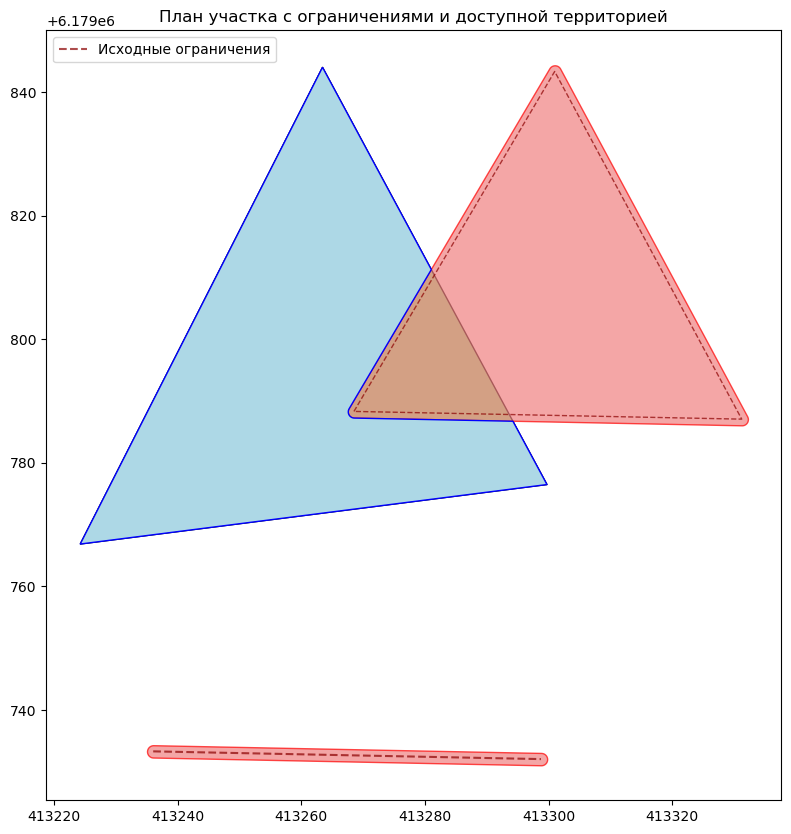

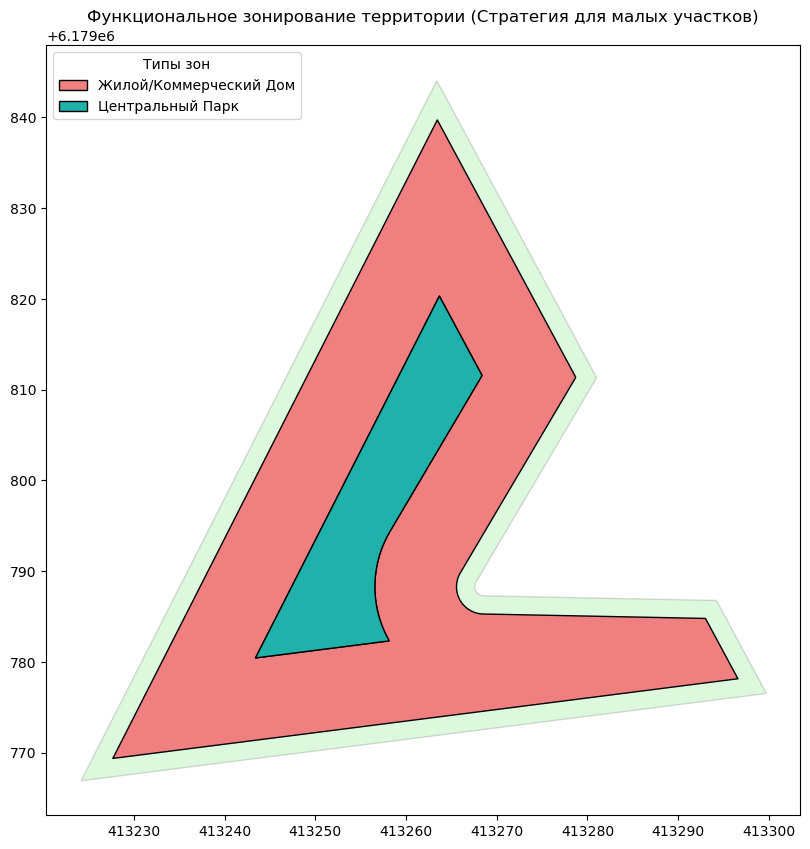

In [49]:
if __name__ == '__main__':
    #filepath = r'F:\Documents\project\project_territory_planning\data\large_area.geojson'
    #filepath = r'F:\Documents\project\project_territory_planning\data\medium_area.geojson'
    filepath = r'F:\Documents\project\project_territory_planning\data\small_area.geojson'

    input_gdf = load_geojson(filepath, TARGET_CRS)

    if input_gdf is None:
        logging.error("Завершение работы из-за ошибки загрузки GeoJSON.")
    else:
        site_polygon, restrictions_gdf = extract_site_and_restrictions(input_gdf)
        if site_polygon is None:
            logging.error("Завершение работы из-за ошибки извлечения участка.")
        else:
            buildable_area = process_restrictions_and_visualize(site_polygon, restrictions_gdf, RESTRICTION_BUFFER_DISTANCE)
            if buildable_area is None:
                logging.error("Завершение работы из-за ошибки обработки ограничений.")
            else:
                target_zone_areas = define_zone_types_and_target_areas(buildable_area, DENSITY_LIMIT)
                if target_zone_areas is not None:
                    zoned_gdf = zone_buildable_area_by_size(buildable_area, input_gdf.crs, LARGE_AREA_THRESHOLD, MEDIUM_AREA_THRESHOLD, LARGE_AREA_THRESHOLD)
                    if zoned_gdf is not None:
                        area_sq_meters = buildable_area.area
                        if area_sq_meters <= SMALL_AREA_THRESHOLD:
                            strategy_name = "Стратегия для малых участков"
                        elif SMALL_AREA_THRESHOLD < area_sq_meters <= MEDIUM_AREA_THRESHOLD:
                            strategy_name = "Стратегия для средних участков"
                        else:
                            strategy_name = "Стратегия для больших участков"

                        logging.info("\nЗонирование территории выполнено успешно:")
                        logging.info(zoned_gdf.head())
                        visualize_zoning(buildable_area, zoned_gdf, title=f'Функциональное зонирование территории ({strategy_name})')
                    else:
                        logging.error("Ошибка зонирования территории: не удалось выполнить зонирование для данного размера участка.")
                else:
                    logging.error("Ошибка расчета целевых площадей зон.")


In [50]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import numpy as np
from shapely.geometry import Polygon, LineString, MultiPoint, box, Point
from shapely.ops import polygonize, voronoi_diagram, unary_union
import random

# --- 1. Data Loading and Extraction ---

def load_geojson(filepath, target_crs="EPSG:32637"):
    """Загружает GeoJSON файл, преобразует в GeoDataFrame и перепроецирует в заданную CRS."""
    try:
        gdf = gpd.read_file(filepath)
        if gdf.crs is None:
            print("Предупреждение: Входной GeoJSON не содержит CRS. Предполагается WGS 84 (EPSG:4326).")
            gdf.crs = "EPSG:4326"
        gdf_projected = gdf.to_crs(target_crs)
        print(f"GeoJSON успешно загружен и перепроецирован в CRS: {target_crs}")
        return gdf_projected
    except FileNotFoundError:
        print(f"Ошибка: Файл не найден по пути: {filepath}")
        return None
    except Exception as e:
        print(f"Ошибка при чтении или перепроекции GeoJSON файла: {e}")
        return None


def extract_site_and_restrictions(input_gdf):
    """Извлекает полигон участка застройки и зоны ограничений из GeoDataFrame."""
    if input_gdf is None:
        print("Ошибка: Передан пустой GeoDataFrame.")
        return None, None

    site_polygon = None
    restrictions_features = []

    for _, row in input_gdf.iterrows():
        if row['name'] == 'Зона застройки':
            site_polygon = row['geometry']
        elif 'restriction' in row and row['restriction'] == 'no_build':
            restrictions_features.append(row)

    if site_polygon is None:
        print("Ошибка: Не найден полигон 'Зона застройки'.")
        return None, None

    restrictions_gdf = gpd.GeoDataFrame(restrictions_features, crs=input_gdf.crs)
    return site_polygon, restrictions_gdf


def process_restrictions_and_visualize(site_polygon, restrictions_gdf, restriction_buffer_distance=1):
    """Обрабатывает зоны ограничений, применяет буфер и вычитает их из участка, визуализирует результат."""
    if site_polygon is None or restrictions_gdf is None:
        print("Ошибка: Неверные входные данные для process_restrictions_and_visualize.")
        return None

    if not restrictions_gdf.empty:
        buffered_restrictions_geoms = [geom.buffer(restriction_buffer_distance) for geom in restrictions_gdf.geometry]
        combined_restrictions = unary_union(buffered_restrictions_geoms)
    else:
        combined_restrictions = None

    buildable_area = site_polygon.difference(combined_restrictions) if combined_restrictions else site_polygon

    fig, ax = plt.subplots(figsize=(10, 10))
    gpd.GeoSeries(site_polygon).plot(ax=ax, facecolor='lightgreen', edgecolor='black', label='Участок')
    if combined_restrictions:
        if hasattr(combined_restrictions, 'geoms'):
            for restriction_geom in combined_restrictions.geoms:
                gpd.GeoSeries(restriction_geom).plot(ax=ax, facecolor='lightcoral', edgecolor='red', label='Ограничения (с буфером)', alpha=0.7)
        else:
            gpd.GeoSeries(combined_restrictions).plot(ax=ax, facecolor='lightcoral', edgecolor='red', label='Ограничения (с буфером)', alpha=0.7)
        original_restrictions = unary_union(restrictions_gdf.geometry)
        if hasattr(original_restrictions, 'geoms'):
            for restriction_geom in original_restrictions.geoms:
                gpd.GeoSeries(restriction_geom).plot(ax=ax, facecolor='none', edgecolor='darkred', linestyle='--', label='Исходные ограничения', alpha=0.7)
        else:
            gpd.GeoSeries(original_restrictions).plot(ax=ax, facecolor='none', edgecolor='darkred', linestyle='--', label='Исходные ограничения', alpha=0.7)

    gpd.GeoSeries(buildable_area).plot(ax=ax, facecolor='lightblue', edgecolor='blue', label='Доступная территория')

    ax.set_title('План участка с ограничениями и доступной территорией')
    ax.legend(loc='upper left')
    ax.set_aspect('equal', adjustable='box')
    plt.show()

    print(f"\nПлощадь доступной для застройки территории: {buildable_area.area:.2f} кв.м")
    return buildable_area

# --- 2. Zoning Strategies ---

def define_zone_types_and_target_areas(buildable_area, density_limit, zone_ratios=None):
    """Определяет типы зон и рассчитывает целевые площади."""
    if buildable_area is None or not 0 <= density_limit <= 1:
        print("Ошибка: Неверные входные данные для define_zone_types_and_target_areas.")
        return None

    zone_types = ['residential', 'commercial', 'park']
    max_build_area = buildable_area.area * density_limit

    if zone_ratios is None:
        zone_ratios = {'residential': 0.6, 'commercial': 0.15, 'park': 0.25}
        print("Используются эвристические соотношения зон:")
    else:
        print("Используются заданные соотношения зон:")
    print(zone_ratios)

    target_zone_areas = {}
    for zone_type in zone_types:
        ratio = zone_ratios.get(zone_type, 0)
        target_zone_areas[zone_type] = max_build_area * ratio

    if sum(zone_ratios.values()) > 1.001:
        print("Предупреждение: Сумма долей зон превышает 100%.")

    print("\nЦелевые площади зон:")
    for zone_type, area in target_zone_areas.items():
        print(f"- {zone_type}: {area:.2f} кв.м")

    return target_zone_areas


def zone_small_area(buildable_area, crs, building_outer_offset=-15, building_inner_offset=-25, road_offset=-5):
    """Зонирует малую территорию."""
    if buildable_area is None or crs is None:
        print("Ошибка: Неверные входные данные для zone_small_area.")
        return None

    contour_road_polygon = buildable_area.buffer(road_offset, cap_style='round')
    if contour_road_polygon.geom_type == 'MultiPolygon':
        contour_road_polygon = max(contour_road_polygon.geoms, key=lambda geom: geom.area)
    contour_road_line = contour_road_polygon.exterior
    outer_building_polygon = contour_road_polygon.buffer(building_outer_offset, cap_style='round')
    inner_building_polygon = contour_road_polygon.buffer(building_inner_offset, cap_style='round')
    building_zone_polygon = outer_building_polygon.difference(inner_building_polygon)
    park_area_polygon = inner_building_polygon

    zones_geometries = [building_zone_polygon, contour_road_line, park_area_polygon]
    zone_types = ['residential_commercial_building', 'road', 'park']
    zone_names = ['Жилой/Коммерческий Дом', 'Контурная Дорога', 'Центральный Парк']
    zones_gdf = gpd.GeoDataFrame(geometry=zones_geometries, data={'type': zone_types, 'name': zone_names}, crs=crs)
    return zones_gdf


def zone_medium_area(buildable_area, crs, min_zone_area=500):
    """Зонирует среднюю территорию."""
    if buildable_area is None or crs is None:
        print("Ошибка: Неверные входные данные для zone_medium_area.")
        return None

    zone_types = ['residential', 'commercial', 'park']
    zone_names = ['Жилая Зона', 'Коммерческая Зона', 'Парковая Зона']
    target_ratios = {'residential': 0.6, 'commercial': 0.2, 'park': 0.2}

    bounds = buildable_area.bounds
    center_x = (bounds[0] + bounds[2]) / 2
    center_y = (bounds[1] + bounds[3]) / 2
    width = bounds[2] - bounds[0]
    height = bounds[3] - bounds[1]

    anchor_points = [
        shapely.geometry.Point(center_x - width/4, center_y),
        shapely.geometry.Point(center_x + width/4, center_y),
        shapely.geometry.Point(center_x, center_y - height/4)
    ]

    voronoi_result = voronoi_diagram(shapely.geometry.MultiPoint(anchor_points))
    voronoi_polygons = []
    if voronoi_result and voronoi_result.geom_type in ('GeometryCollection', 'MultiPolygon', 'Polygon'): # More robust check
        for geom in getattr(voronoi_result, 'geoms', [voronoi_result]): # Use getattr for safe iteration
            if geom.geom_type == 'Polygon':
                voronoi_polygons.append(geom)
    else:
        print("Предупреждение: voronoi_diagram вернула неожиданный результат.")
        return None

    voronoi_gdf_preliminary = gpd.GeoDataFrame(geometry=voronoi_polygons, crs=crs)

    assigned_zones = []
    zone_index = 0
    for _, voronoi_row in voronoi_gdf_preliminary.iterrows():
        zone_polygon = voronoi_row['geometry'].intersection(buildable_area)
        if not zone_polygon.is_empty and zone_polygon.area > min_zone_area:
            zone_type = zone_types[zone_index % len(zone_types)]
            zone_name = zone_names[zone_index % len(zone_types)]
            assigned_zones.append({'geometry': zone_polygon, 'type': zone_type, 'name': zone_name})
            zone_index += 1

    zones_gdf = gpd.GeoDataFrame(assigned_zones, crs=crs, geometry='geometry')
    return zones_gdf


def zone_commercial_center_area(block_polygon, crs):
    """Зонирует квартал под коммерческий центр."""
    return gpd.GeoDataFrame([{'geometry': block_polygon, 'type': 'commercial_center', 'name': 'Коммерческий Центр'}], crs=crs, geometry='geometry')


def zone_park_area(block_polygon, crs):
    """Зонирует квартал под парк."""
    return gpd.GeoDataFrame([{'geometry': block_polygon, 'type': 'park_area', 'name': 'Парковая Зона'}], crs=crs, geometry='geometry')


def zone_large_area(buildable_area, crs, min_zone_area=600):
    """Зонирует большую территорию."""
    if buildable_area is None or crs is None:
        print("Ошибка: Неверные входные данные для zone_large_area.")
        return None

    road_network_gdf = generate_boundary_and_internal_roads(buildable_area, crs, small_area_threshold=15000)
    road_network_union = unary_union(road_network_gdf.geometry)
    blocks_polygons = polygonize(unary_union([road_network_union, buildable_area.boundary]))

    blocks_gdf_preliminary = gpd.GeoDataFrame(geometry=list(blocks_polygons), crs=crs)
    blocks_gdf = blocks_gdf_preliminary[blocks_gdf_preliminary.within(buildable_area)]

    # 3. Классификация кварталов по типам зон (Residential, Commercial, Park)
    num_blocks = len(blocks_gdf)
    num_commercial_blocks = max(1, int(num_blocks * 0.15))
    num_park_blocks = max(1, int(num_blocks * 0.15))
    num_residential_blocks = num_blocks - num_commercial_blocks - num_park_blocks

    block_types = ['residential'] * num_residential_blocks + ['commercial_center'] * num_commercial_blocks + ['park_area'] * num_park_blocks
    if len(block_types) > num_blocks:
        block_types = block_types[:num_blocks]
    elif len(block_types) < num_blocks:
        block_types += ['residential'] * (num_blocks - len(block_types))
    np.random.shuffle(block_types)

    blocks_gdf['zone_type'] = block_types

    zones = []
    for _, block_row in blocks_gdf.iterrows():
        block_polygon = block_row['geometry']
        block_type = block_row['zone_type']

        if block_type == 'residential':
            small_area_zones_gdf = zone_small_area(block_polygon, crs)
            if small_area_zones_gdf is not None:
                zones.extend(small_area_zones_gdf.to_dict('records'))
        elif block_type == 'commercial_center':
            commercial_center_zones_gdf = zone_commercial_center_area(block_polygon, crs)
            if commercial_center_zones_gdf is not None:
                zones.extend(commercial_center_zones_gdf.to_dict('records'))
        elif block_type == 'park_area':
            park_zones_gdf = zone_park_area(block_polygon, crs)
            if park_zones_gdf is not None:
                zones.extend(park_zones_gdf.to_dict('records'))

    zones_gdf = gpd.GeoDataFrame(zones, crs=crs, geometry='geometry')
    return zones_gdf


def generate_boundary_and_internal_roads(buildable_area, crs, boundary_offset_large=-10, road_spacing_large=80,
                                        boundary_offset_small=-5, road_spacing_small=60,
                                        min_road_length_ratio=0.6, small_area_threshold=15000):
    """Генерирует дорожную сеть."""
    if buildable_area is None or crs is None:
        print("Ошибка: Передан пустой buildable_area или CRS не определен.")
        return None

    area_sq_meters = buildable_area.area

    boundary_offset = boundary_offset_large if area_sq_meters > small_area_threshold else boundary_offset_small
    road_spacing = road_spacing_large if area_sq_meters > small_area_threshold else road_spacing_small

    boundary_road_polygon = buildable_area.buffer(boundary_offset)
    boundary_road = boundary_road_polygon.exterior

    minx, miny, maxx, maxy = buildable_area.bounds
    horizontal_lines = [LineString([(minx, y), (maxx, y)]) for y in np.arange(miny, maxy, road_spacing)]
    vertical_lines = [LineString([(x, miny), (x, maxy)]) for x in np.arange(minx, maxx, road_spacing)]

    internal_road_segments_initial = []
    for line in horizontal_lines + vertical_lines:
        intersection = boundary_road_polygon.intersection(line)
        if not intersection.is_empty:
            if intersection.geom_type == 'LineString':
                internal_road_segments_initial.append(intersection)
            elif intersection.geom_type == 'MultiLineString':
                internal_road_segments_initial.extend(intersection.geoms)

    internal_roads_filtered_segments = [
        segment for segment in internal_road_segments_initial if segment.length >= road_spacing * min_road_length_ratio
    ]

    roads_geometries = [boundary_road] + internal_roads_filtered_segments
    road_types = ['boundary'] + ['internal'] * len(internal_roads_filtered_segments)

    road_network_gdf = gpd.GeoDataFrame(geometry=roads_geometries, data={'type': road_types}, crs=crs)
    return road_network_gdf

def zone_buildable_area_by_size(buildable_area, crs, small_area_threshold=15000, medium_area_threshold=30000, large_area_threshold=30000):
    """Выбирает стратегию зонирования в зависимости от размера участка."""
    if buildable_area is None or crs is None:
        print("Ошибка: Неверные входные данные для zone_buildable_area_by_size.")
        return None

    area_sq_meters = buildable_area.area

    zoned_gdf = None
    placed_objects_gdf = None
    strategy_name = ""

    if area_sq_meters <= small_area_threshold:
        print(f"Участок классифицирован как малый ({area_sq_meters:.2f} кв.м). Применяется стратегия для малых территорий.")
        zoned_gdf = zone_small_area(buildable_area, crs)
        strategy_name = "Стратегия для малых участков"
        placed_objects_gdf = place_objects_small_area(zoned_gdf, buildable_area, crs) # Place objects for small areas
    elif small_area_threshold < area_sq_meters <= medium_area_threshold:
        print(f"Участок классифицирован как средний ({area_sq_meters:.2f} кв.м). Применяется стратегия для средних территорий.")
        zoned_gdf = zone_medium_area(buildable_area, crs)
        strategy_name = "Стратегия для средних участков"
        placed_objects_gdf = None # No object placement for medium areas yet
    elif area_sq_meters > large_area_threshold:
        print(f"Участок классифицирован как большой ({area_sq_meters:.2f} кв.м). Применяется стратегия для больших территорий.")
        zoned_gdf = zone_large_area(buildable_area, crs)
        strategy_name = "Стратегия для больших участков"
        placed_objects_gdf = None # No object placement for large areas yet
    else:
        print(f"Для территорий от {medium_area_threshold:.2f} кв.м до {large_area_threshold:.2f} кв.м пока не реализовано зонирование.")
        return None, None, None  # Return None for placed_objects_gdf as well

    return zoned_gdf, placed_objects_gdf, strategy_name


# --- 3. Visualization ---

def visualize_zoning(buildable_area, zoned_gdf, placed_objects_gdf, title='Функциональное зонирование территории'):
    """Визуализирует зонирование территории и размещение объектов."""
    if buildable_area is None or zoned_gdf is None:
        print("Ошибка: Неверные входные данные для visualize_zoning.")
        return

    fig, ax = plt.subplots(figsize=(10, 10))
    gpd.GeoSeries(buildable_area).plot(ax=ax, facecolor='lightgreen', edgecolor='gray', alpha=0.3, label='Доступная для застройки территория')

    handles = []
    zone_colors = {
        'residential_commercial_building': 'lightcoral',
        'road': 'gray',
        'park': 'lightseagreen',
        'residential': 'lightyellow',
        'commercial_center': 'lightsalmon',
        'park_area': 'lightgreen',
        'house': 'white',          # White color for houses
        'park_road': 'lightgray'    # Light gray for park roads
    }

    # --- Plot zones ---
    for _, row in zoned_gdf.iterrows():
        zone_type = row['type']
        zone_name = row['name']
        zone_geometry = row['geometry']

        if not zone_geometry.is_empty:
            if zone_geometry.geom_type == 'LineString':
                gpd.GeoSeries(zone_geometry).plot(ax=ax, color=zone_colors.get(zone_type, 'black'), linewidth=2, label=None)
                handles.append(Line2D([0], [0], color=zone_colors.get(zone_type, 'black'), lw=2, label=zone_name))
            elif zone_geometry.geom_type in ('Polygon', 'MultiPolygon'):
                gpd.GeoSeries(zone_geometry).plot(ax=ax, facecolor=zone_colors.get(zone_type, 'lightgray'), edgecolor='black', linewidth

_IncompleteInputError: incomplete input (3599246387.py, line 362)